In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.


# 14.1 시각피질 구조

- 원숭이, 고양이 대상으로 그림 인식 실험
     - 뇌의 일부분만 활성화 되더라. 
     - 그럼 NN도 층을 일부만 사용해서 그림을 인식할 수 있지 않을까? 
--- 
- LeNet-5 $\rightarrow$ convolution layer와 pooling layer를 소개
---
#### Convolution?

- (뒤집고) 밀면서(shift) 곱해서 더했다. 라고 생각
<br>
- 수식 참고 $(f*g)(t) = \int^\inf_{-\inf}f(\gamma)g(t-\gamma)d\gamma$ ← 정확한지는 모르겠음..?
---
##### 왜 이미지 인식에서는 완전연결 잘 사용 안하지?
- 파라미터 수가 너무 많아진다.
    - 이미지가 큰 경우, 100 x 100 이미지라고 하면 10000픽셀
    - 뉴런 1000개만 만들어도 연결이 1천만개 생김.
    - 더 커지면,,,? 계산 비용이 너무 크다.

# 14.2 합성곱 층
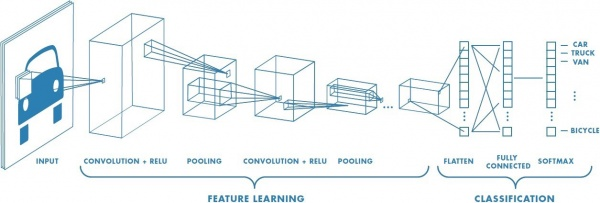
#### Convolution layer
- 필터를 이동(shift)시키면서 곱한다 -> shift정도에 따라 output이 달라진다.
    - CNN 뉴런은 이미지의 모든 픽셀에 연결되지 않고 특정 부분만 연결됨.
    
- size가 안맍으면 0을 채워넣기도 한다 << zero padding
    - 높이와 너비를 이전 층과 같게 하기 위해 입력의 주위에 0을 추가?
    - 음,,, 맞는 말이긴 하다.
    - 그러면 높이와 너비를 같게 하지 않아도 될 때는 padding을 안해도 되나?
        - 그것은 또 아닌 것 같음. 
        - 패딩이라는 것은 궁극적으로 정보의 손실을 막기 위해서 하는 것이다?
---
- 이 책에서는 **filter를 수용장**이라고 함.
    - Filter가 움직이는 정도를 ***stride***라고 한다.

## 14.2.1 필터
- **Filter**에 대한 설명
- 층의 전체 뉴련에 적용된 하나의 필터는 하나의 ***특성 맵(feature map)***을 만든다.
    - 훈련하는 동안 convolution layer가 가장 유용한 필터를 찾게 됨.

## 14.2.2 여러가지 특성 맵 쌓기
- 실제 사용하는 convolution layer는 여러가지 필터를 가지고있고, 필터마다 하나의 특성 맵을 출력한다.
    - 그래서 3D로 표현하는 것이 보통 더 정확함.
---
- ***특성 맵의 픽셀 = 하나의 뉴런***
    - 하나의 feature map에선 모든 뉴런이 같은 파라미터를 공유.
    - 다른 feature map에서는 다른 파라미터.
---
- 일반적으로 이미지가 ***컬러라면 R,G,B 3개의 channel***을 가진다.
    - 어떤 경우는 엄청 많은 channel을 가질 수도 있다.


#### 수식으로 정리 
- 굉장히 복잡해 보인다. 뜯어보면 생각보단 쉬울수도,,,?
- $z_{i,j,k} = b_k +\sum^{f_h-1}_{u=0}\sum^{f_w-1}_{v=0}\sum^{f_n'-1}_{k'=0}x_{i',j',k'}\times w_{u,v,k',k}$<br><br>
    - 이 때, $i' = i \times s_h + u$, $j' = j \times s_w + v$
    <br><br>
    - $z_{i,j,k}$: Convolution layer ($l$층)의 $k$ feature map에서 $i$행, $j$열에 위치한 뉴런의 출력
    - $s_h, s_w$: 수직, 수평 스트라이드(fiter가 shift하는 정도)
    - $f_h, f_w$: filter의 높이와 너비
    - $f_{n'}$: 이전 층($l-1$층)에 있는 feature map의 개수
    - $x_{i',j',k'}$: $l-1$층의 $i'$행 $j'$열, $k'$ feature map 에 있는 뉴런의 출력
    - $b_k$: $l$레이어에 있는 특성 맵의 편향
    - $w_{u,v,k',k}$: $l$층의 $k$특성 맵에 있는 모든 뉴런과 $u$행, $v$열, 그리고 $k'$ feature map에 위치한 입력 사이의 연결 가중치

## 14.2.3 텐서플로 구현

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

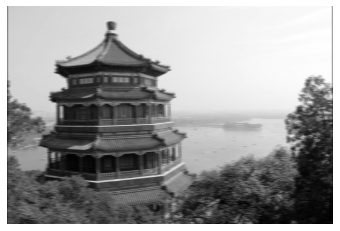

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# 샘플 이미지를 로드합니다.
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 2개의 필터를 만듭니다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # 첫 번째 이미지의 두 번째 특성맵을 그립니다.
plt.axis("off") # 책에는 없습니다.
plt.show()

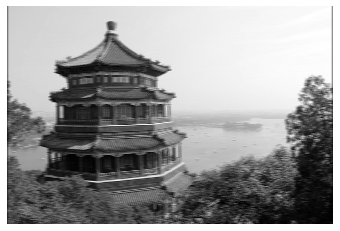

In [4]:
import tensorflow as tf
outputs = tf.nn.conv2d(images, filters, strides= 1, padding="SAME")
            #images: 입력의 미니배치(4D 텐서형태)
            #padding -> 'same': 필요한 경우 zero padding 진행(이 경우 output크기: 입력 뉴련수/stride 를 올림한 것)
                                #
                        #'valid': zero padding 진행하지 않음.(입력 이미지의 어떤 부분이 무시될수도 있음)
#plt.imshow(outputs[0, ..., 1], cmap='gray') #첫번째 이미지의 2번째 특성 맵
#plt.show()
plot_image(outputs[0, :, :, 1])

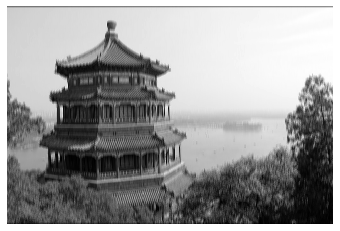

In [5]:
plot_image(outputs[0, :, :, 0]) #오 약간 차이가 있다.

In [6]:
from tensorflow import keras
conv = keras.layers.Conv2D(filters = 32, kernel_size = 3, strides =1, padding= 'same',
                           activation = 'relu')
        #filter 32개, filter size는 3 x 3, zero padding(필요하면), stride = 1

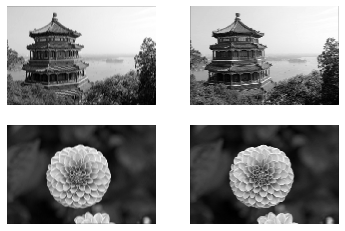

In [7]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

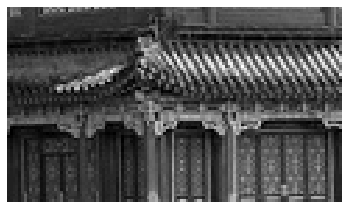

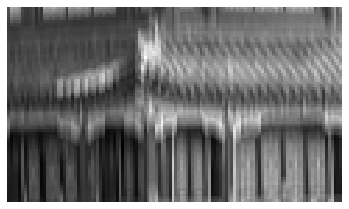

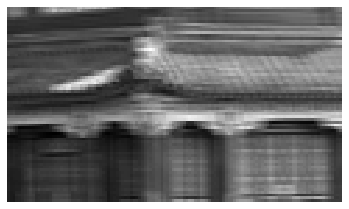

In [8]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

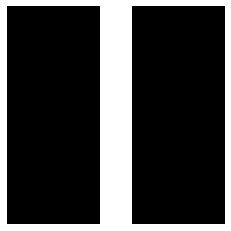

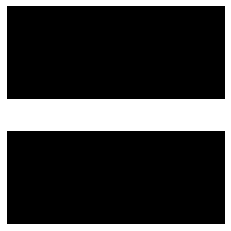

In [9]:
#filter 확인하기
plot_image(filters[:, :, :, 0])
plt.show()
plot_image(filters[:, :, :, 1])
plt.show()

## 14.2.4 메모리 요구사항 

- CNN의 convolution layer는 많은 양의 RAM을 필요로한다.
    - 메모리 부족으로 훈련이 안되면
    1. 미니배치 크기를 줄이기
    2. 스트라이드를 사용해 차원 줄이기
    3. 몇 개의 층 제거하기
    4. 32비트 부동소수 대신 16비트 부동소수 이용하기
    5. 여러장치에 CNN 분산시키기

# 14.3 풀링 층
- 목적: 계산량, 메모리 사용량, 파라미터 수 줄이기 위해 입력 이미지의 subsample 만들기
#### 1. 최대 풀링(max pooling)
- 장점:
    - 작은 변화에도 일정 수준의 ***불변성(invariance)***을 만들어준다.
    - 가장 큰 특징만 유지하기 때문에 다음 층이 조금 더 명확한 신호로 작업할 수 있다.
    - 연산 비용이 덜 든다.

- 단점: 매우 파괴적이다.
    - 입력값의 많은 부분을 잃어버릴 수 있다. 

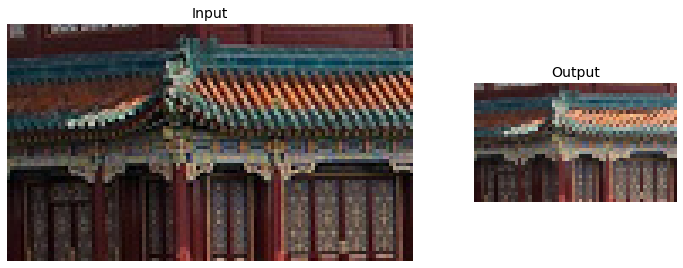

In [10]:
max_pool = keras.layers.MaxPool2D(pool_size =2)
cropped_images = np.array([crop(image) for image in images], dtype = np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0]) #(0, 0)위치에 그림그리기
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1]) #(0, 1)위치에 그림 그리기
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

## 14.3.1 텐서플로 구현
#### 2. 평균 풀링 층(average pooling layer)
- 평균을 계산하여 pooling
    - 일반적으로 max pooling이 더 성능이 좋아서 대부분 maxpooling 사용
    - max pooling에 비해 정보 손실이 적다.

In [11]:
avg_pool = keras.layers.AveragePooling2D(pool_size = 2)
output_avg = avg_pool(cropped_images)

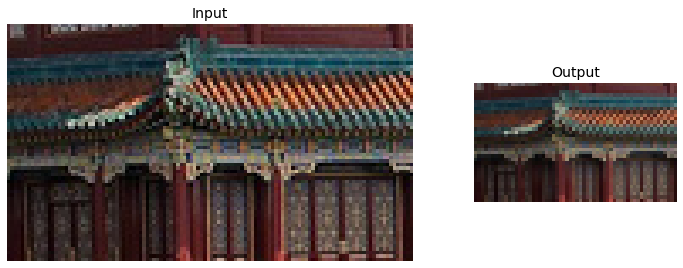

In [12]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

##### 3. 깊이 방향(depth-wise) 풀링
- CNN이 다양한 특성에 대한 불변성을 학습.
    - 두께, 밝기, 회전, 왜곡, 생상 등에 대한 불변성 학습

In [13]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [14]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

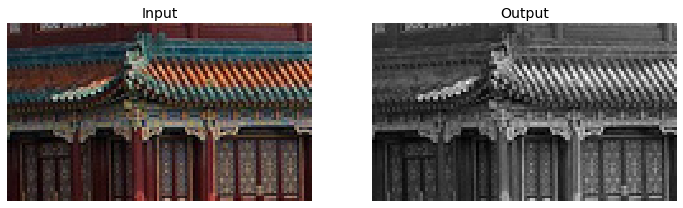

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

###### ```lambda```를사용할 수 있다.

In [16]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))

##### 4. 전역 평균 풀링(global average pooling)
- 각 특성 맵의 평균을 계산.
    - 각 샘플의 특성 맵마다 하나의 숫자를 출력 
    - 정보를 많이 잃지만, 출력층에는 유용할 수 있음.
    - ```keras.layers.GlobalAvgPool```을 사용

In [17]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# 14.4 CNN의 구조

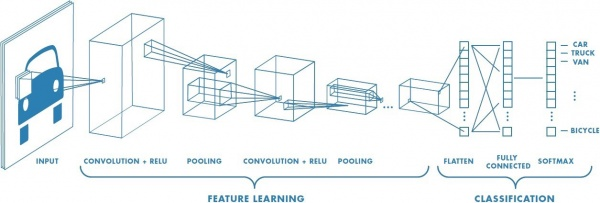

- 입력 -> 합성곱 + relu -> 풀링 -> 합성곱 + relu -> 풀링 -> fully connected
- 보통 첫번째 합성곱 층을 제외하고는 작은 filter 여러개를 사용하는 것이 일반적.(계산량이 적고, 일반적으로 좋은 성능을 보이기 때문)
    - 첫번째 합성곱층에서는 큰 필터를 사용하여 많은 정보를 잃지 않고, 공간 방향 차원을 줄일 수 있다.

In [30]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")
#partial로 묶어주기

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2), #64개의 filter, filter size = 7 x 7
    #픽셀이 28 x 28이고 흑백이므로 channel = 1
    #pooling size 2 -> 공간 방향 차원을 절반으로 줄이기
    DefaultConv2D(filters=128), #128개의 filter, 나머지는 동일 
    DefaultConv2D(filters=128), #128개의 filter, 나머지는 동일
    keras.layers.MaxPooling2D(pool_size=2), #max pooling, size =2이므로 절반으로 줄임
    DefaultConv2D(filters=256), #256개의 filter 
    DefaultConv2D(filters=256), #256개의 filter
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(), #1D 배열로 만들어준다.
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5), #과대적합 방지를 위한 드롭아웃
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])
#출력층에 가까워질수록 filter의 개수가 늘어남.(일반적인 경우)


## 14.1.1 LeNet-5

- 손글씨 숫자 인식(MNIST)에 널리 사용됨.
- MNIST의 이미지는 28 x 28 => zero padding 하여 32 x 32로 만들고 정규화 한 다음 NN에 주입
    - NN의 다른 부분에서는 패딩 사용X
---
- 출력층은 각 뉴런에서 입력 벡터와 가중치 벡터 사이의 유클리드 거리를 출력.
    - 출력은 이미지가 얼마나 특정 숫자 클래스에 속하는 지 측정.

## 14.4.2 AlexNet
- 더 크고 깊을 뿐 LeNet-5와 유사함
- 합성곱 층 위에 pooling없이 바로 합성곱을 쌓았다.
- LRN(local response normalization) 사용
    - 경쟁적인 정규화 단계
    - 가장 강하게 활성화된 뉴런이 다른 특성 맵에 있는 같은 위치의 뉴런을 억제한다.

---
###### AlexNet의 두 가지 규제 기법
1. 완전연결 층에 드롭아웃 50% 적용
2. data augmentation 적용

## 14.4.3 GoogLeNet
- 이전의 CNN구조보다 훨씬 깊게 만들어서 성능을 높임
- 인셉션 모듈(inception module)이라는 서브 네트워크를 가지고 있어서 훨씬 효과적으로 파라미터 사용.
    - 파라미터는 AlexNet보다 10배 적다.
---
###### 인셉션 모듈의 구조
- 모두 스트라이드 1, 'same'패딩 사용. 
    - 따라서, 출력의 높이와 너비가 모두 입력과 같아진다.
    - 인셉션 모듈은 깊이 차원을 따라 놓인 패턴을 잡을 수 있다.
    - 입력보다 더 적은 특성 맵을 출력하므로 병목 층(bottle neck)의 역할을 담당한다. 
    

## 14.4.4 VGGNet
- 단순하고 고전적인 구조
    - 2개 또는 3개의 합성곱 층 뒤에 풀링층이 나오고 다시 2개 또는 3개의 합성곱 층과 풀링층이 등장
    - 필터의 개수는 많지만 , 3x3 필터만 사용한다.

## 14.4.5 ResNet
- Resiudal Network(잔차 네트워크)를 사용하여 CNN의 성능을 높임
    - 핵심: ***skip connection(shortcut connection)***
    - 이를 통해 입력 신호가 전체 네트워크에 손쉽게 영향을 미친다.
    - 심층 잔차 네트워크는 residual unit을 쌓은 것으로 볼 수 있다.